<a href="https://colab.research.google.com/github/Rakib911Hossan/Al_Project/blob/main/Emotion_detedction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

Class distribution:
label
1    30
0    30
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Train Loss: 0.6956 | Acc: 0.5000 | F1: 0.2222
Val Loss: 0.7135 | Acc: 0.4444 | F1: 0.0000
Patience 1/3

Epoch 2/10


Train Loss: 0.7025 | Acc: 0.5476 | F1: 0.2400
Val Loss: 0.7089 | Acc: 0.4444 | F1: 0.0000
Patience 2/3

Epoch 3/10


Train Loss: 0.6924 | Acc: 0.5238 | F1: 0.2308
Val Loss: 0.7035 | Acc: 0.4444 | F1: 0.0000
Patience 3/3
Early stopping triggered
No improvement during training. Using final model.


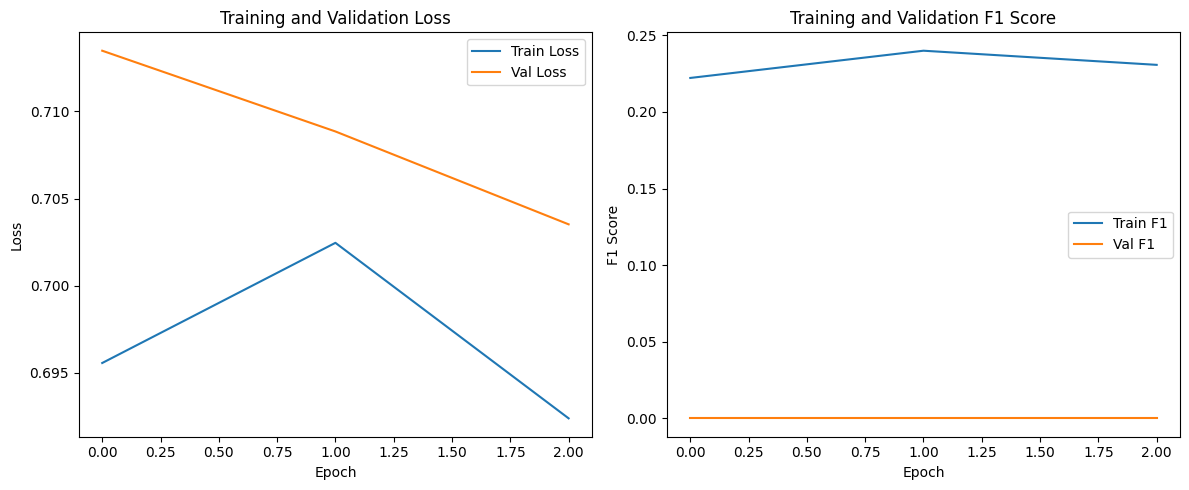

Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(


Detailed Test Results:
                       precision    recall  f1-score   support

           No Concern       0.56      1.00      0.71         5
Mental Health Concern       0.00      0.00      0.00         4

             accuracy                           0.56         9
            macro avg       0.28      0.50      0.36         9
         weighted avg       0.31      0.56      0.40         9



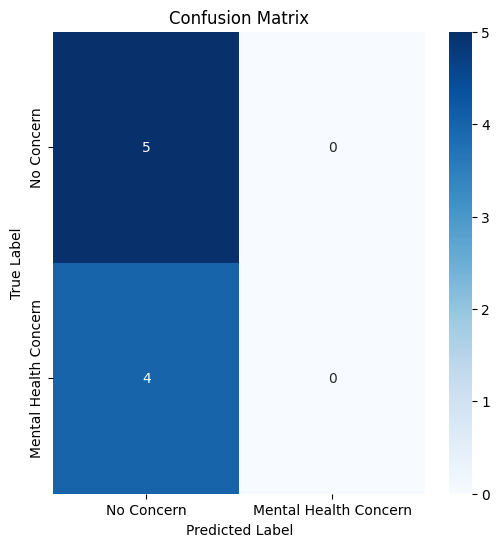


Sample Predictions with Thresholding (0.7):

Tweet: 'Please don't talk to me, I need some medicines'
Cleaned: 'please do not talk to me, i need some medicines'
Prediction: Uncertain (confidence below threshold)
Confidence: 0.5374
Probabilities: No Concern: 0.5374, Mental Health Concern: 0.4626
Above threshold: False

Tweet: 'Just got promoted at work! So excited!'
Cleaned: 'just got promoted at work! so excited!'
Prediction: Uncertain (confidence below threshold)
Confidence: 0.5382
Probabilities: No Concern: 0.5382, Mental Health Concern: 0.4618
Above threshold: False

Tweet: 'Sometimes I wonder if anyone would notice if I was gone'
Cleaned: 'sometimes i wonder if anyone would notice if i was gone'
Prediction: Uncertain (confidence below threshold)
Confidence: 0.5364
Probabilities: No Concern: 0.5364, Mental Health Concern: 0.4636
Above threshold: False

Tweet: 'Going on vacation next week, can't wait!'
Cleaned: 'going on vacation next week, can not wait!'
Prediction: Uncertain (confi

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## 1. Enhanced Data Loading and Preprocessing
def clean_tweet(text):
    """Advanced preprocessing for social media text"""
    # Convert emojis to text descriptions
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags (keep text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Handle contractions and slang
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # Remove special characters except basic punctuation
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def load_enhanced_data():
    """Load and preprocess a more comprehensive dataset"""
    # Expanded dataset with more nuanced examples
    data = {
        'text': [

            "I can't stop worrying about everything lately, it's exhausting",
            "Nothing brings me joy anymore, everything feels meaningless",
            "The anxiety is crushing me today, can't even leave my bed",
            "I feel so alone in this world, like no one understands me",
            "Why does everything feel so hopeless? I see no way out",
            "The stress is making it hard to breathe, chest feels tight",
            "I don't think I can handle this anymore, it's too much",
            "Woke up feeling anxious for no reason, heart racing",
            "Medication isn't working anymore, what's the point?",
            "The depression fog is so thick today, can't think straight",
            "Suicidal thoughts keep creeping in, I'm scared",
            "Panic attack at work, had to leave early",
            "Self-harm urges are getting stronger",
            "Crying randomly again, can't explain why",
            "Even small tasks feel impossible to complete lately",
            "I wish I could just disappear for a while",
            "My thoughts have been dark again, it scares me",
            "The pressure is unbearable, I'm constantly overwhelmed",
            "Can't get out of bed, what's the point of trying?",
            "I've been pretending to be okay, but I'm not",
            "Exhausted from battling my mind every day",
            "Lost interest in everything I used to love",
            "Every night I hope I don't wake up",
            "I'm tired of pretending that I'm fine",
            "My chest feels tight and I can't breathe properly",
            "The sadness won't go away no matter what I do",
            "I feel like a burden to everyone around me",
            "Nothing seems to help this constant emptiness",
            "I'm so tired of fighting these thoughts",
            "The pain is too much to bear today",

            # No concern examples (label=0)
            "Feeling fantastic today! The sun is shining and I got a promotion!",
            "Had a productive day at work, finished all my tasks",
            "Looking forward to the weekend getaway with friends",
            "Just had coffee with friends, feeling connected and happy",
            "Completed my project ahead of schedule! Boss was impressed",
            "Enjoying a relaxing day at home with my favorite book",
            "Excited about my new hobby, painting is so therapeutic",
            "Planning a fun trip with family, can't wait to see them",
            "Achieved my fitness goal today! Feeling accomplished",
            "Had a great therapy session, making progress",
            "Volunteered at the shelter today, so rewarding",
            "My support system is amazing, so grateful",
            "Practicing mindfulness really helps me stay grounded",
            "Started a new book series—it's amazing so far",
            "Cooking dinner with my partner tonight!",
            "Just finished my morning run, feeling energized!",
            "Watched a great movie last night with friends.",
            "Went out for brunch and laughed so much today!",
            "Grateful for the little joys in life lately",
            "Started journaling again, it's helping me reflect",
            "Finally redecorated my room—feels refreshing!",
            "Enjoyed some quality time with my dog today",
            "Making progress on my personal goals—feeling proud",
            "Had a delicious meal and feel really satisfied",
            "I'm learning a new language and it's fun!",
            "Beautiful weather today, went for a long walk",
            "Finished that difficult task I've been putting off",
            "Had a great conversation with an old friend",
            "Treated myself to a spa day, much needed",
            "Found a new coffee shop I really love",

        ],
        'label': [1]*30 + [0]*30
    }

    df = pd.DataFrame(data)
    df['text'] = df['text'].apply(clean_tweet)
    return df

df = load_enhanced_data()

# Check class balance
print("\nClass distribution:")
print(df['label'].value_counts())

# Split into train, validation, and test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=seed, stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=seed, stratify=temp_labels
)

# Reset indices
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

## 2. Enhanced Model Initialization
MODEL_NAME = 'roberta-base'

# Custom configuration with enhanced settings
config = RobertaConfig.from_pretrained(MODEL_NAME)
config.num_labels = 2
config.hidden_dropout_prob = 0.3  # Increased dropout for better regularization
config.attention_probs_dropout_prob = 0.3
config.classifier_dropout = 0.2  # Additional classifier dropout

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
).to(device)

## 3. Enhanced Dataset Class
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = MentalHealthDataset(train_texts, train_labels, tokenizer)
val_dataset = MentalHealthDataset(val_texts, val_labels, tokenizer)
test_dataset = MentalHealthDataset(test_texts, test_labels, tokenizer)

# Create data loaders with weighted sampling
from torch.utils.data import WeightedRandomSampler

# Calculate class weights for sampler
class_counts = np.bincount(train_labels)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = class_weights[train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

batch_size = 16  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 4. Enhanced Training Setup
epochs = 10  # Increased epochs with early stopping
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # Adjusted learning rate
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

## 5. Enhanced Training Loop with Metrics Tracking
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    total = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        losses.append(loss.item())

        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({
            'loss': np.mean(losses[-10:]),
            'acc': correct_predictions/total
        })

    accuracy = correct_predictions / total
    f1 = f1_score(all_labels, all_preds)
    return accuracy, np.mean(losses), f1

def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs.logits, labels)
            losses.append(loss.item())

            probs = torch.softmax(outputs.logits, dim=1)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct_predictions / total
    f1 = f1_score(all_labels, all_preds)
    return accuracy, np.mean(losses), f1, all_preds, all_labels, all_probs

## 6. Run Training with Early Stopping and Metrics Tracking
best_f1 = 0
patience = 3
current_patience = 0
best_model = None

train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_acc, train_loss, train_f1 = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler
    )
    val_acc, val_loss, val_f1, _, _, _ = evaluate(model, val_loader, loss_fn, device)

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    # Early stopping based on validation F1
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = model.state_dict()
        current_patience = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Validation F1 improved. Saving model.")
    else:
        current_patience += 1
        print(f"Patience {current_patience}/{patience}")
        if current_patience >= patience:
            print("Early stopping triggered")
            break

# Load best model
if best_model is not None:
    model.load_state_dict(best_model)
    print("Loaded best model based on validation F1 score.")
else:
    print("No improvement during training. Using final model.")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1')
plt.plot(val_f1s, label='Val F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Comprehensive Evaluation
def detailed_evaluation(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            probs = torch.softmax(outputs.logits, dim=1)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return all_preds, all_labels, all_probs

test_preds, test_labels, test_probs = detailed_evaluation(model, test_loader, device)

print("\nDetailed Test Results:")
print(classification_report(test_labels, test_preds, target_names=['No Concern', 'Mental Health Concern']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Concern', 'Mental Health Concern'],
            yticklabels=['No Concern', 'Mental Health Concern'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Enhanced Prediction Function with Thresholding
def predict_mental_health(text, model, tokenizer, device, max_len=128, threshold=0.7):
    """Predict with confidence thresholding and detailed output"""
    # Clean text
    text = clean_tweet(text)

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    probs = torch.softmax(outputs.logits, dim=1)
    confidence, prediction = torch.max(probs, dim=1)
    confidence = confidence.item()

    # Apply threshold
    if confidence < threshold:
        prediction_label = "Uncertain (confidence below threshold)"
    else:
        prediction_label = "Mental Health Concern" if prediction.item() == 1 else "No Concern"

    result = {
        'text': text,
        'prediction': prediction_label,
        'confidence': confidence,
        'probabilities': {
            'No Concern': probs[0][0].item(),
            'Mental Health Concern': probs[0][1].item()
        },
        'threshold': threshold,
        'is_above_threshold': confidence >= threshold
    }

    return result

# Test with sample tweets
sample_tweets = [
    "Please don't talk to me, I need some medicines",
    "Just got promoted at work! So excited!",
    "Sometimes I wonder if anyone would notice if I was gone",
    "Going on vacation next week, can't wait!",
    "The darkness never seems to lift, no matter what I do",
    "Celebrating my anniversary with my wonderful partner",
    "I've been having panic attacks daily, it's unbearable",
    "Completed my first marathon today! What an achievement!",
    "I don't see the point in anything anymore",
    "Had an amazing day with friends at the beach"
]

print("\nSample Predictions with Thresholding (0.7):")
for tweet in sample_tweets:
    result = predict_mental_health(tweet, model, tokenizer, device)
    print(f"\nTweet: '{tweet}'")
    print(f"Cleaned: '{result['text']}'")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: No Concern: {result['probabilities']['No Concern']:.4f}, "
          f"Mental Health Concern: {result['probabilities']['Mental Health Concern']:.4f}")
    print(f"Above threshold: {result['is_above_threshold']}")

In [ ]:
## 8. Enhanced Prediction Function with Confidence Scores
def predict_mental_health(text, model, tokenizer, device, max_len=128):
    """Predict with confidence scores and preprocessing"""
    # Clean text
    text = clean_tweet(text)

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    probs = torch.softmax(outputs.logits, dim=1)
    confidence, prediction = torch.max(probs, dim=1)

    result = {
        'prediction': "Mental Health Concern" if prediction.item() == 1 else "No Concern",
        'confidence': confidence.item(),
        'probabilities': {
            'No Concern': probs[0][0].item(),
            'Mental Health Concern': probs[0][1].item()
        }
    }

    return result

# Test with sample tweets
sample_tweets = [
    "be careful!, he died there",
    "Just got promoted at work! So excited!",
    "Sometimes I wonder if anyone would notice if I was gone",
    "Going on vacation next week, can't wait!",
    "The darkness never seems to lift, no matter what I do",
    "Celebrating my anniversary with my wonderful partner",
    "I've been having panic attacks daily, it's unbearable",
    "Completed my first marathon today! What an achievement!"
]

print("\nSample Predictions:")
for tweet in sample_tweets:
    result = predict_mental_health(tweet, model, tokenizer, device)
    print(f"\nTweet: '{tweet}'")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
    print(f"Probabilities: No Concern: {result['probabilities']['No Concern']:.4f}, "
          f"Mental Health Concern: {result['probabilities']['Mental Health Concern']:.4f}")


Sample Predictions:

Tweet: 'be careful!, he died there'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5479, Mental Health Concern: 0.4521

Tweet: 'Just got promoted at work! So excited!'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5493, Mental Health Concern: 0.4507

Tweet: 'Sometimes I wonder if anyone would notice if I was gone'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5471, Mental Health Concern: 0.4529

Tweet: 'Going on vacation next week, can't wait!'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5489, Mental Health Concern: 0.4511

Tweet: 'The darkness never seems to lift, no matter what I do'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5474, Mental Health Concern: 0.4526

Tweet: 'Celebrating my anniversary with my wonderful partner'
Prediction: No Concern (Confidence: 0.55)
Probabilities: No Concern: 0.5475, Mental Health Concern: 0.4525

Tweet: